In [41]:
from itertools import product
import torch
from torchvision.transforms import ToTensor
from torchvision import datasets
from pysr import PySRRegressor
from model import CNN
import pandas as pd
import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
import seaborn as sb

### Load Model and get Kernels

In [2]:
cnn = CNN()
cnn.load_state_dict(torch.load('cnn.pt'))
print(cnn)

for name, param in cnn.named_parameters():
    if name == 'conv1.weight':
        print(f"amount of kernels of Conv1: {param.shape}")
        kernels1 = param
    if name == 'conv2.weight':
        print(f"amount of kernels of Conv2: {param.shape}")
print(f"kernels of first layer:\n{kernels1}")

/tmp/ipykernel_9886/3040839533.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load('cnn.pt'))


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
amount of kernels of Conv1: torch.Size([16, 1, 5, 5])
amount of kernels of Conv2: torch.Size([32, 16, 5, 5])
kernels of first layer:
Parameter containing:
tensor([[[[-0.2335, -0.2440, -0.9097, -1.0703, -0.8168],
          [-0.0917,  0.0114, -0.2991, -0.3230,  0.6103],
          [ 0.0865,  0.0287,  0.0781,  0.3111,  0.9103],
          [ 0.0553, -0.7562, -0.8900, -0.9722, -0.9644],
          [ 0.0107, -0.6425, -0.8105, -0.5706, -1.1133]]],


        [[[-0.0280, -0.6446, -1.0783, -0.0510, -0.1909],
          [-1.2921, -1.5182, -0.0516,  0.5699, -0.5167],
          [-

### Load Dataset and get results

In [3]:
test_data = datasets.MNIST(root='data', train=False, transform=ToTensor(),)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True, num_workers=1)
samples, labels = next(iter(test_loader))

cnn.eval()
with torch.no_grad():
    results = cnn(samples)

### Prepare Data for PySR and extract features
Extract the 5x5 submatrices (incl. padding) from images to use them as input

In [4]:
# Take every image and split it into 5x5 submatrices => np.array.shape = (7840, 5, 5)
# 7840 <- 28 * 28 patches per image * 10 images (batch_size)
kernel_size = 5
X = None
for x in samples:
    x = torch.nn.functional.pad(input=x[0], pad=(2, 2, 2, 2), mode="constant", value=0)
    for i, j in np.ndindex((x.size()[0] - kernel_size + 1, x.size()[1] - kernel_size + 1)):
        slice = x[i:i + kernel_size, j:j + kernel_size]
        if X is None:
            # X = np.array([slice.numpy().flatten()])
            X = np.array([slice.numpy()])
        else:
            # X = np.concatenate((X, [slice.numpy().flatten()]))
            X = np.concatenate((X, [slice.numpy()]))

print(X.shape)

# Get the result for every 5x5 submatrix for each kernel => np.array.shape = (16, 7840)
# 16 <- amount of kernels in the first layer
y = results['relu1'].numpy().transpose(1, 0, 2, 3).reshape(16, X.shape[0])
print(y.shape)

(15680, 5, 5)
(16, 15680)


#### Discrete Cosine Transform (DCT, Fourier Transform)
Get DCT features of image, only keep low frequencies.

In [5]:
def dct2(m):
    return dct(dct(m.T, norm='ortho').T, norm='ortho')

Xdct = np.array(list(map(dct2, X)))
dct_filter_param = 3
Xdct_filtered = np.array(list(map(lambda m: m[:dct_filter_param, :dct_filter_param], Xdct)))
print(Xdct_filtered.shape)

(15680, 3, 3)


Figures of corresponding frequencies

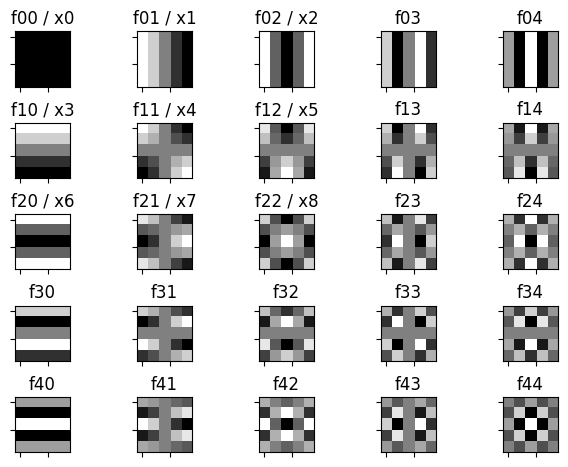

In [134]:
fig, axs = plt.subplots(5,5)
fig.tight_layout(h_pad=0.5, w_pad=0)
for i, j in list(product(range(5), range(5))):
    img = np.zeros((5, 5))
    img[i, j] = 1
    axs[i, j].imshow(idct(idct(img.T, norm='ortho').T, norm='ortho'), cmap='gray')
    axs[i, j].set_yticklabels([])
    axs[i, j].set_xticklabels([])
    if i < 3 and j < 3:
        axs[i, j].set_title(f"f{i}{j} / x{3*i + j}")
    else:
        axs[i, j].set_title(f"f{i}{j}")

### Symbolic Regression

In [ ]:
def newPySRRegressor():
    return PySRRegressor(
        niterations=40,
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[
            "cos",
            "exp",
            "sin",
            "square",
            "cube",
            "inv(x) = 1/x",  # Julia syntax
        ],
        extra_sympy_mappings={"inv": lambda x: 1 / x},  # Sympy syntax
        elementwise_loss="loss(prediction, target) = (prediction - target)^2",  # Julia syntax
        warm_start=False,
        verbosity=0,
        temp_equation_file=True,
    )

#### Over the first kernel

In [ ]:
regr_first_kernel = newPySRRegressor()
regr_first_kernel.fit(Xdct_filtered.reshape(X.shape[0], dct_filter_param**2), y[0])  # Input data coded for position and summed

In [ ]:
print(regr_first_kernel.equations_['lambda_format'])
f = regr_first_kernel.equations_['lambda_format'][4]
print(f(np.array(range(9))))

#### Over all 16 Kernels

In [ ]:
regr_all_kernels = pd.DataFrame()
regr_all_kernels.index.names = ['complexity']
for i in range(16):
    regr = newPySRRegressor()
    regr.fit(Xdct_filtered.reshape((X.shape[0], dct_filter_param**2)), y[i])  # Input data as is
    # print(regr.equations_)
    regr_all_kernels.insert(loc=i, column=f'Kernel {i}', value=regr.equations_['equation'])
    print(f"Done with Kernel {i} | {(i+1)/16 * 100}%")

print(regr_all_kernels)

In [ ]:
regr_all_kernels.to_csv('results_dct_filter3_allkernels.csv')

#### Over the first kernel multiple times (Stability check)

In [ ]:
regr_stability = pd.DataFrame()
regr_stability.index.names = ['complexity']
for i in range(10):
    regr = newPySRRegressor()
    regr.fit(Xdct_filtered.reshape((X.shape[0], dct_filter_param**2)), y[0])
    # print(regr.equations_)
    regr_stability.insert(loc=i, column=f'Iteration {i}', value=regr.equations_['equation'])
    # print(regr_stability)
    print(f"Done with Iteration {i} | {(i+1)/10 * 100}%")

In [ ]:
regr_stability.to_csv('results_dct_filter3_stability.csv')

### Analysis of the results

#### Distribution of variables in functions
First, see how often each variable occurs in the functions for all complexity levels in each kernel.  
Then look at the overall distribution of variable usage.

In [72]:
# Count variable occurance for each kernel
df_res_all_kernels = pd.read_csv('results_dct_filter3_allkernels.csv', index_col='complexity').fillna("")
variables = dct_filter_param**2 + 0

df_variable_occurences_all = pd.DataFrame()
df_variable_occurences_all.index.names = ['Kernel']
summed_all = df_res_all_kernels.sum()
for i in range(variables):
    df_variable_occurences_all.insert(loc=i, column=f"x{i}", value=[s.count(f"x{i}") for s in summed_all])
display(df_variable_occurences_all)

,x0,x1,x2,x3,x4,x5,x6,x7,x8
Kernel,,,,,,,,,
0,1,0,1,4,1,0,8,0,0
1,6,0,7,0,0,9,0,0,0
2,8,1,5,0,3,0,0,1,0
3,3,3,4,0,8,0,0,0,0
4,0,0,0,8,0,2,0,4,0
5,0,8,0,0,0,7,0,0,0
6,0,5,0,14,0,0,0,0,0
7,6,1,0,8,1,0,6,0,0
8,7,0,0,2,5,0,4,2,0


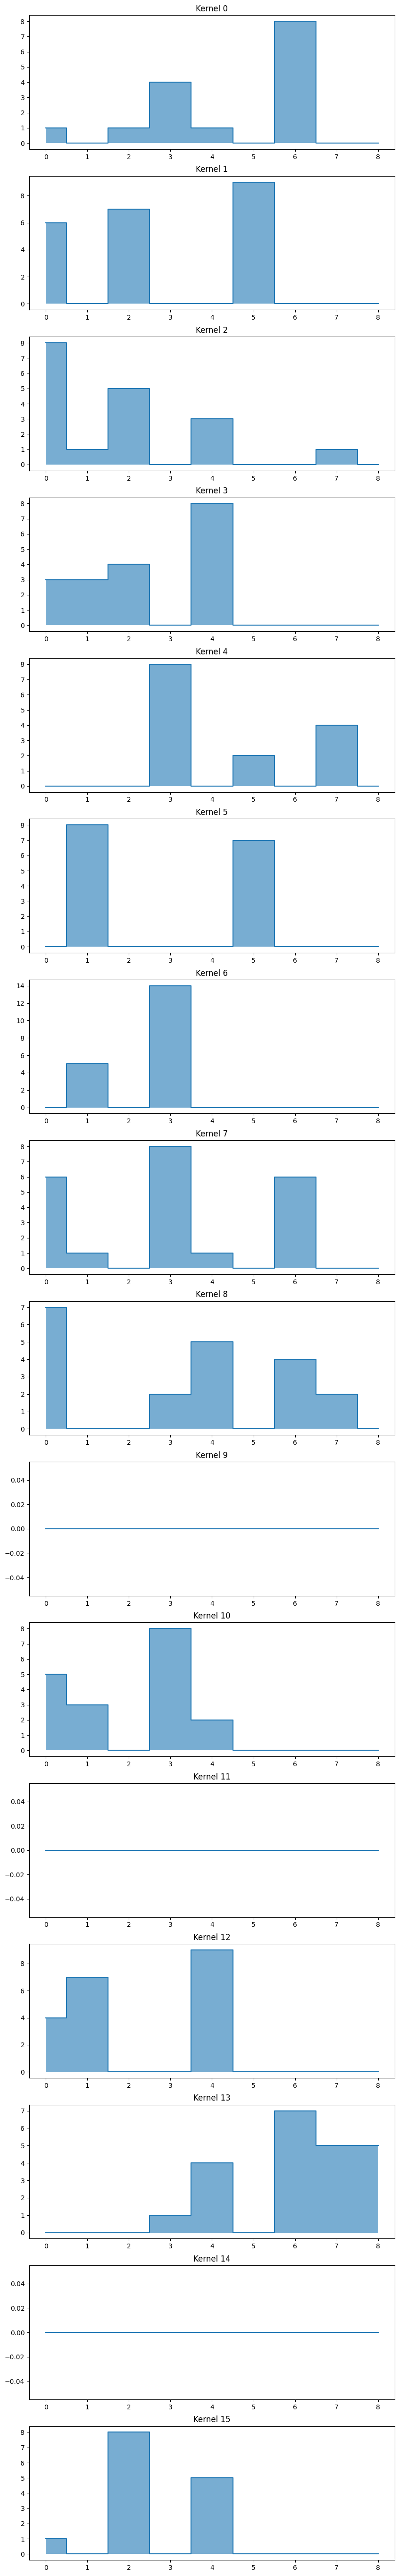

In [119]:
# Plot the occurances for each kernel
fig_all, axs_all = plt.subplots(df_variable_occurences_all.shape[0], figsize=(10, 70))
for i, ax in enumerate(axs_all):
    ax.step(range(variables), df_variable_occurences_all.loc[i], where='mid')
    ax.fill_between(range(variables), df_variable_occurences_all.loc[i], step="mid", alpha=0.6)
    ax.set(title=f"Kernel {i}")#, xlim=[0,variables-1], ylim=[0,20])

Text(0.5, 1.0, 'All Kernels')

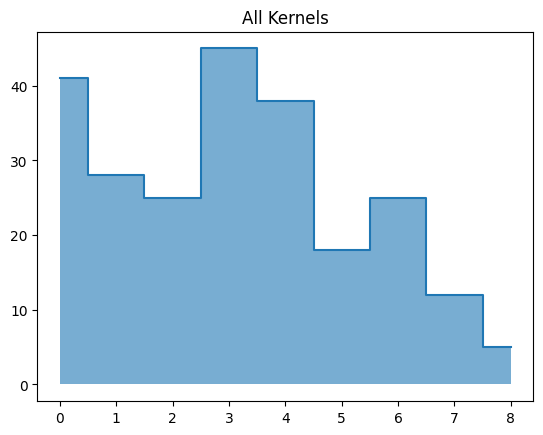

In [117]:
# Plot the occurances over all kernels
plt.step(range(variables), df_variable_occurences_all.sum(), where='mid')
plt.fill_between(range(variables), df_variable_occurences_all.sum(), step='mid', alpha=0.6)
plt.title("All Kernels")

#### Stability on first Kernel
See if throughout different iterations the same variable is important for Kernel 1.

In [120]:
# Count variable occurance for each iteration
df_res_stability = pd.read_csv('results_dct_filter3_stability.csv', index_col='complexity').fillna("")
variables = dct_filter_param**2 + 0

df_variable_occurences_stab = pd.DataFrame()
df_variable_occurences_stab.index.names = ['Iteration']
summed_stab = df_res_stability.sum()
for i in range(variables):
    df_variable_occurences_stab.insert(loc=i, column=f"x{i}", value=[s.count(f"x{i}") for s in summed_stab])
display(df_variable_occurences_stab)

,x0,x1,x2,x3,x4,x5,x6,x7,x8
Iteration,,,,,,,,,
0,0,0,0,11,0,1,11,0,0
1,0,0,1,7,0,0,12,0,1
2,3,0,0,5,3,2,12,0,0
3,0,0,0,3,1,0,8,0,0
4,0,0,0,6,0,0,10,0,0
5,0,0,0,18,0,0,11,0,1
6,0,0,0,8,0,0,10,0,0
7,0,1,0,5,0,0,10,0,0
8,0,0,0,8,0,0,12,0,0


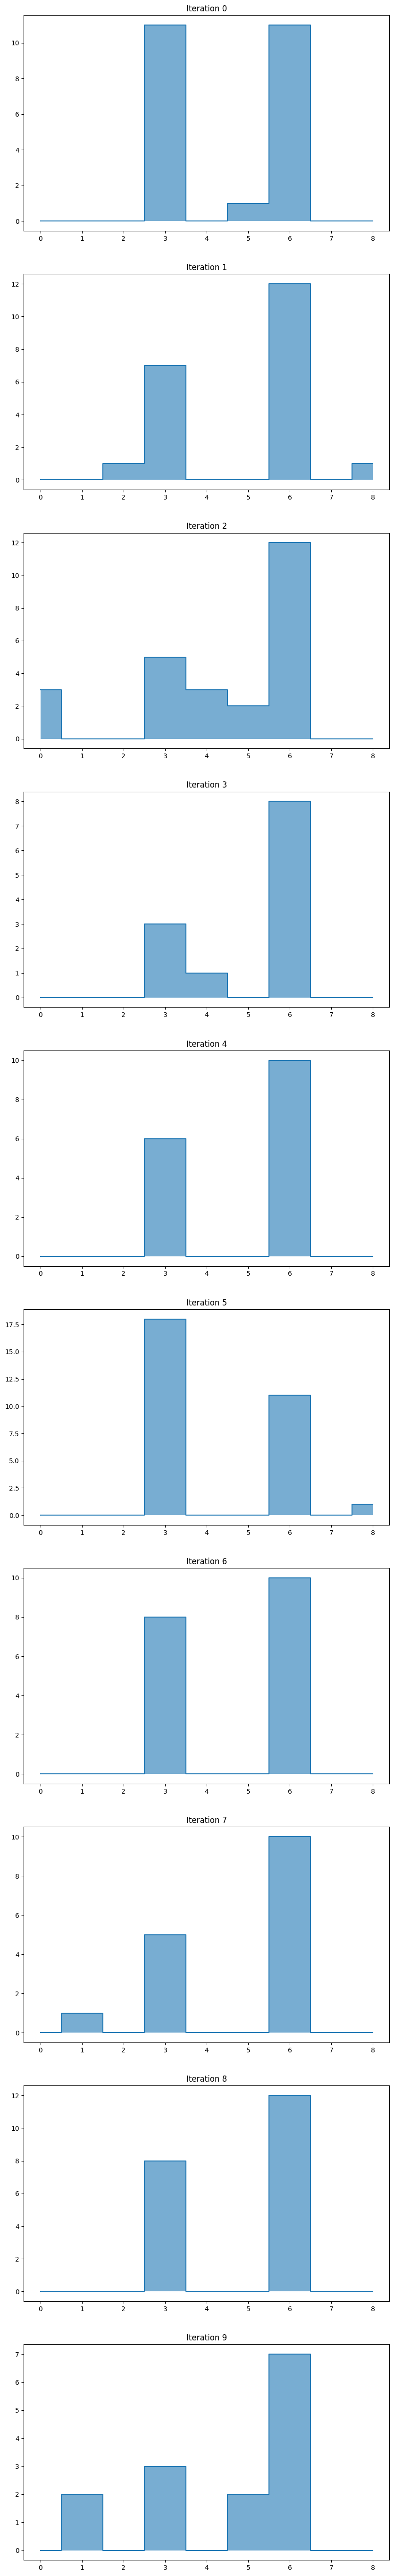

In [121]:
# Plot the occurances for each kernel
fig_stab, axs_stab = plt.subplots(df_variable_occurences_stab.shape[0], figsize=(10, 70))
for i, ax in enumerate(axs_stab):
    ax.step(range(variables), df_variable_occurences_stab.loc[i], where='mid')
    ax.fill_between(range(variables), df_variable_occurences_stab.loc[i], step="mid", alpha=0.6)
    ax.set(title=f"Iteration {i}")#, xlim=[0,variables-1], ylim=[0,20])

Text(0.5, 1.0, 'All Iterations')

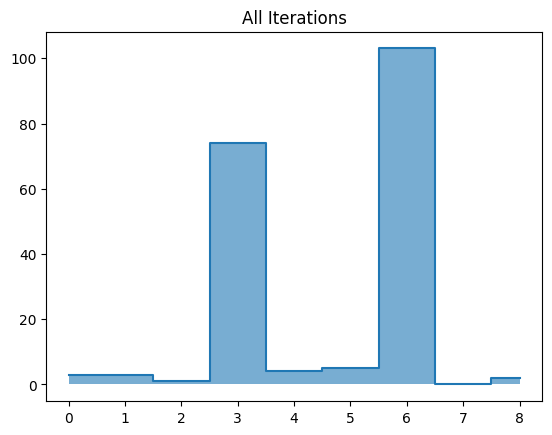

In [122]:
# Plot the occurances over all kernels
plt.step(range(variables), df_variable_occurences_stab.sum(), where='mid')
plt.fill_between(range(variables), df_variable_occurences_stab.sum(), step='mid', alpha=0.6)
plt.title("All Iterations")

Kernel 1 seems to pay special attention to x3 and x6, which are the horizontal frequencies.
Let's see if something like this can be recognized in the kernel...

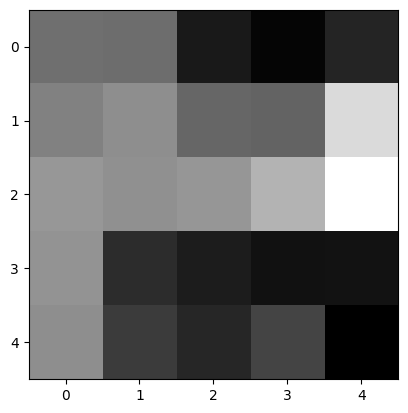

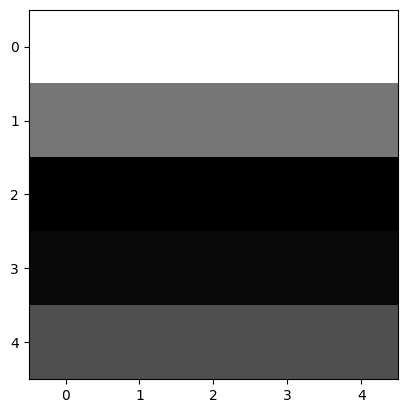

In [141]:
plt.figure(0)
plt.imshow(kernels1[0].detach().numpy()[0], cmap='gray')

x36 = np.zeros((5, 5))
x36[1, 0] = 1
x36[2, 0] = 1
plt.figure(1)
plt.imshow(idct(idct(x36.T, norm='ortho').T, norm='ortho'), cmap='gray')